In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pprint,sys
from icecream import ic
from scipy.integrate import simpson
import pandas as pd

In [38]:
def normalize(beta, sigma0, nyear=1024, n=5000):

    # Frequency grid (avoid ν=0)
    nu_start = 0.5 / nyear
    nu_end   = 0.5 * (nyear - 1) / nyear 
    nu = np.linspace(nu_start, nu_end, n)

    # Raw (unnormalized) power
    P = nu**(-beta)
    s = simpson(P, x=nu)

    a = (sigma0**2) / s
    return a, nu

def xir(a, drought_length, tau, beta, nu):
 
    tau = np.atleast_1d(tau)                
    L = drought_length
    arg = np.pi * nu * L                    
    window_sq = np.sinc(arg / np.pi)**2     

    # Spectrum
    Pnu = a * nu**(-beta) * window_sq       

    # Cosine term cos(2πντ) for all τ: outer product
    cos_term = np.cos(2.0 * np.pi * np.outer(tau, nu))   

    # Integrand and integrate over ν (axis=1)
    integrand = cos_term * Pnu
    xi_tau = simpson(integrand, x=nu, axis=1)
    return xi_tau if xi_tau.size > 1 else xi_tau.item()

# -------------------------------
# Parameters
# -------------------------------

sigma0 = 4.5     
nyear  = 1000
n      = 5000
tau = np.arange(1, 101, 1)   
drought_length = 20
dfs = {}

# Normalize spectrum
beta_values = [0, 0.5, 1]   

for b in beta_values:
    # Normalize for this beta
    a, nu = normalize(b, sigma0, nyear=nyear, n=n)

    # Compute ξ(τ)
    xi = xir(a, drought_length, tau, b, nu)

    # Optional: print rounded values
    for t, val in zip(tau, np.round(xi, 2)):
        print(f"beta={b}, tau={t:>3d}, xi={val: .2f}")

    # Save to Excel for this beta
    df = pd.DataFrame({"tau": tau, "xi": np.round(xi, 2)})
    df.to_excel(f"correlation_{b}.xlsx", index=False)

    
# quick plot
#try:
    #plt.figure()
    #plt.plot(tau, xi)
    #plt.xlabel(r'$\tau$ (years)')
    #plt.ylabel(r'$\xi(\tau)$')
    #plt.title('Correlation function with drought window')
    #plt.tight_layout()
    #plt.show()
#except Exception as e:
    #pass
    

beta=0, tau=  1, xi= 0.94
beta=0, tau=  2, xi= 0.89
beta=0, tau=  3, xi= 0.84
beta=0, tau=  4, xi= 0.79
beta=0, tau=  5, xi= 0.74
beta=0, tau=  6, xi= 0.69
beta=0, tau=  7, xi= 0.64
beta=0, tau=  8, xi= 0.59
beta=0, tau=  9, xi= 0.54
beta=0, tau= 10, xi= 0.49
beta=0, tau= 11, xi= 0.44
beta=0, tau= 12, xi= 0.39
beta=0, tau= 13, xi= 0.33
beta=0, tau= 14, xi= 0.28
beta=0, tau= 15, xi= 0.23
beta=0, tau= 16, xi= 0.18
beta=0, tau= 17, xi= 0.13
beta=0, tau= 18, xi= 0.08
beta=0, tau= 19, xi= 0.03
beta=0, tau= 20, xi=-0.02
beta=0, tau= 21, xi=-0.02
beta=0, tau= 22, xi=-0.02
beta=0, tau= 23, xi=-0.02
beta=0, tau= 24, xi=-0.02
beta=0, tau= 25, xi=-0.02
beta=0, tau= 26, xi=-0.02
beta=0, tau= 27, xi=-0.02
beta=0, tau= 28, xi=-0.02
beta=0, tau= 29, xi=-0.02
beta=0, tau= 30, xi=-0.02
beta=0, tau= 31, xi=-0.02
beta=0, tau= 32, xi=-0.02
beta=0, tau= 33, xi=-0.02
beta=0, tau= 34, xi=-0.02
beta=0, tau= 35, xi=-0.02
beta=0, tau= 36, xi=-0.02
beta=0, tau= 37, xi=-0.02
beta=0, tau= 38, xi=-0.02
beta=0, tau=

In [39]:
def nearestPD(A):
    """Returns single value decomposition of A Matrix"""
    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3
    
    spacing = np.spacing(np.linalg.norm(A))

    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False
    
def calcmu(Kstar_star,K,K_star,sigma2_n,flow,nstar):
    L = np.linalg.cholesky(K + sigma2_n*np.eye(len(Year)))
    v = np.linalg.solve(L, K_star)
    mu = mean +np.dot(v.T, np.linalg.solve(L, flow)).reshape((nstar,))

    return mu

def cov(a,b,beta):
    
    df = pd.read_excel(f"correlation_{beta}.xlsx")
    dt = df["tau"].values
    xi = df["xi"].values
    #dt, xi = np.loadtxt(f'kaiserxi15.{beta}.dat', unpack=True)
    ab = np.zeros((len(a), len(b)))
    for i in range(len(a)): 
        for j in range(len(b)):
            tt = abs(a[i]-b[j])
            m = int(tt)
            if (m <= 100):
               ab[i][j] = xi[m]
            else:
               ab[i][j] = 0.02
    return ab

In [46]:
df = pd.read_excel("Measured Streamflow in MAF.xlsx")
years_me = df.iloc[:, 0].values
flows_me = df.iloc[:, 1].values

# 15-year centered moving average
window = 15
flows_smoothed_end = pd.Series(flows_me).rolling(window=15, closed='right').mean().values
#mask = ~np.isnan(flows_smoothed)
mask = years_me >= 1920
years_filtered = years_me[mask]
flows_filtered = flows_smoothed_end[mask]

# --- Combine into two-column array ---
data_to_save = np.column_stack((years_filtered, flows_filtered))

# --- Save as text file ---
np.savetxt("Smoothed_Streamflow_1920onward.txt", data_to_save,
           fmt="%.0f %.4f", header="Year  Smoothed_Streamflow_MAF", comments='')

print("✅ File saved as 'Smoothed_Streamflow_1920onward.txt'")

✅ File saved as 'Smoothed_Streamflow_1920onward.txt'


In [47]:
Yeardat, Flowdat = years_filtered, flows_filtered

# --- Error model and centering ---
FlowErrordat = Flowdat * 0.13
mean = Flowdat.mean()
flowdat = Flowdat - mean
sigma2_n = np.var(FlowErrordat)
#sigma2_n = np.mean(FlowErrordat**2)
sigma2 = np.var(flowdat)

# --- Prediction years (2015–2050 inclusive) ---
YearStar = np.arange(2024, 2050)             # 1-D (needed for cov)
nstar = len(YearStar)

# --- Calibration/observed subset years (1995–2015 inclusive) ---
yb, ye = 2004, 2024
Year = np.arange(yb, ye + 1)                 # 1-D
ny = ye - yb + 1

# Align the last `ny` entries of the full record (1920–2015 => length should be 96)
n_total = len(flowdat)                        # should be 96 for 1920–2015
ist = n_total - ny
idx = np.arange(ist, n_total)                 # last ny indices

flow = flowdat[idx]
Flow = Flowdat[idx]
FlowError = FlowErrordat[idx]

betas = [0, 0.5, 1]                           
mu_by_beta = {}

for beta in betas:
    # Ensure cov() receives 1-D arrays
    Kstar_star = cov(YearStar, YearStar, beta)   # (nstar x nstar)
    K          = cov(Year,     Year,     beta)   # (ny x ny)
    K_star     = cov(Year,     YearStar, beta)   # (ny x nstar)  

    mu_by_beta[beta] = calcmu(Kstar_star, K, K_star, sigma2_n, flow, nstar)

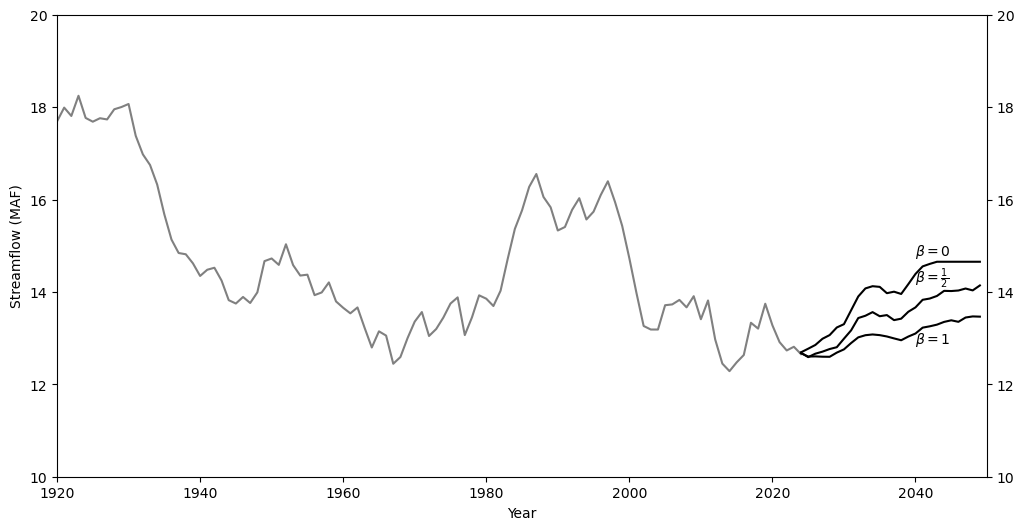

In [48]:
yearmin = 1920
plt.figure(figsize=(12,6), dpi=100)
plt.xlabel('Year')
plt.ylabel('Streamflow (MAF)')
plt.axis([yearmin, 2050, 10, 20])
#plt.title(r'Effect of varying the $\beta$ parameter ')
plt.plot (Yeardat, Flowdat , color ='grey')
plt.plot(YearStar, mu_by_beta[0],  'k')
plt.plot(YearStar, mu_by_beta[1],  'k')
plt.plot(YearStar, mu_by_beta[0.5], 'k')
#plt.legend()
plt.tick_params('y',labeltop=False, labelright=True, right=True)
plt.text(2040, 14.8, r'$\beta=0$')
plt.text(2040, 12.9, r'$\beta=1$')
plt.text(2040, 14.2, r'$\beta=\frac{1}{2}$')
plt.show()